# CT2FE example 02
## CT dataset to tethraedra mesh and FE model solution in Calculix
14.01.2021

The preprocessing of this example is performed in 3D Slicer using the extension [SlicerSegmenterMesher](https://github.com/lassoan/SlicerSegmentMesher#tutorial). <br />
This extension of 3D Slicer allows the creation of volumetric meshes from segmented 3D data using Cleaver2 or TetGen. <br />
The full SlicerSegmentMesher tutorial can be found here:
https://github.com/lassoan/SlicerSegmentMesher#tutorial  <br />
For info on the solver see the Calculix homepage:
http://www.calculix.de/

#### Activate CT2FE kernel in Jupyter:
`conda env list`

`conda activate CT2FE`

`python -m ipykernel install --user --name CT2FE --display-name "Python (CT2FE)"`

## Basic configurations

In [317]:
import os
import numpy as np
import tifffile
import dxchange
import matplotlib
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

matplotlib.rcParams['figure.dpi'] = 150

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

In [284]:
%%html
<style>
table {float:left}
</style>

In [311]:
def read_tiff_stack(filename):
    # Read a stack of tiffs from single slice filename.
    # Searches all files in parent folder and opens them as a stack of images.
    # TO DO:
    #     - check that folder contains only .TIFF files; skip the rest

    # search all files in parent folder; create filenames list
    tifffiles = [os.path.join(os.path.dirname(filename), f) for f in os.listdir(os.path.dirname(filename))
                     if os.path.isfile(os.path.join(os.path.dirname(filename), f))]
    tifffiles.sort()

    # load stack using tifffile
    return tifffile.imread(tifffiles)

In [318]:
def plot_midplanes(data_3D, slice_x=int(data_3D.shape[1]/2), slice_y=int(data_3D.shape[2]/2), slice_z=int(data_3D.shape[0]/2)):
    # Plot midplanes of 3D data
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(data_3D[slice_z, :, :])
    ax2.imshow(data_3D[:, slice_x, :])
    ax3.imshow(data_3D[:, :, slice_y])

#### Inputs and parameters definition

In [291]:
input_file = '/home/gianthk/Data/TOMCAT/Kaya/D_single_h1h2_scale05/D_single_h1h2_scale050001.tif'
# filename_in, ext = os.path.split(input_file)

Input data description

|Scan parameters|   |
|:-|:-|
|Beamline|TOMCAT@SLS|
|Sample|Sintered steel foam strut from [Kaya_2016](10.1016/j.matdes.2016.05.069)|
|Energy|34 keV|
|Camera|PCO.edge5|
|Optics|10x|
|Voxel size|0.65 /mum|
|Notes|Two Z-scans merged; downsampled @ 5X and quadratic interpolation|

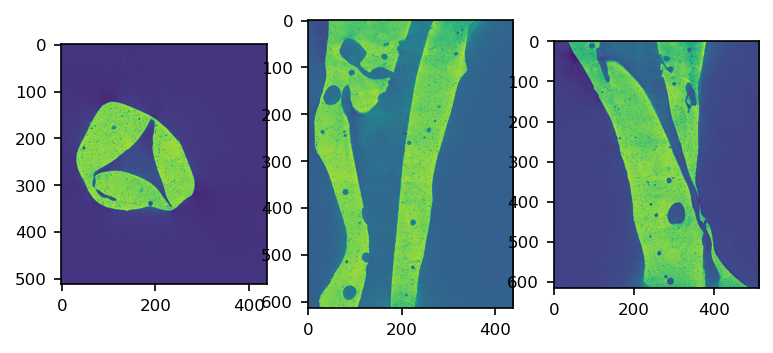

In [319]:
# Preview input 3D data
data_3D = read_tiff_stack(input_file)
plot_midplanes(data_3D)

## Pre-processing
The following steps are performed in [3D Slicer](https://www.slicer.org/)
- [x] **3D rotate** (**Transforms** module). Apply a rigid rotation (manual) along P-A and R-L planes to align the strut vertically. 
![](test_data/example_02/3DSlicer_transform.png)
- [x] **Orient Scalar Volume** (**Converters** module): Orientation: axial (NO)
- [x] **Crop Volume** (**Converters** module): limit the model size and flattens the strut top and bottom
- [x] **3D global threshold** (Kittler-Illingworth)
    - [x] Smooth with closing method (fill holes)
    - [x] Invert (twice) and remove small islands
    - [x] Add the large pores segmented separately
    - [x] Median smoothing
- [x] **Segmenter Mesher**
    - Feature scaling: 0.8
    - Sampling rate: 0.5
    - Rate of change el size: 0.4



## Modify VTK unstructured grid mesh and generate Abaqus/CalculiX input
We need to modify the mesh in the following way: <br />

- [ ] Add points sets for boundary nodes: NODES_S, NODES_N, NODES_E, NODES_W, NODES_T, NODES_B
- [ ] Add elemets sets for boundary elements: ELEMS_S, ELEMS_N, ELEMS_E, ELEMS_W, ELEMS_T, ELEMS_B
- [ ] Add material property section
- [ ] Add definition of FE analysis (boudary conditions, non-linear geometry including material plasticity, quasi-static time-steps)

We use the module *meshio* to import the mesh. 

In [1]:
import meshio

In [334]:
# inspect the input mesh
input_file_mesh = '/home/gianthk/Data/TOMCAT/Kaya/D_single_h1h2_3DSlicer/D_single.vtk' # unstructured grid VTK file exported in 3D Slicer
mesh = meshio.read(input_file_mesh)
vars(mesh)

{'points': array([[303.579   , 306.325   , 104.5993  ],
        [297.65    , 312.2541  ,  98.670296],
        [303.7763  , 324.3659  , 104.6251  ],
        ...,
        [ 83.271996, 193.76599 , 362.8216  ],
        [ 83.311   , 193.76599 , 365.02863 ],
        [ 83.590996, 193.76599 , 367.2356  ]], dtype=float32),
 'cells': [<meshio CellBlock, type: tetra, num cells: 742468>],
 'point_data': {},
 'cell_data': {'labels': [array([1, 1, 1, ..., 1, 1, 1], dtype=int32)]},
 'field_data': {},
 'point_sets': {},
 'cell_sets': {},
 'gmsh_periodic': None,
 'info': None}

## mesh2Abaqus.py
The script mesh2Abaqus.py reads the .VTK unstructured grid mesh exported by 3D Slicer and converts it to Abaqus input file (.INP) for solution in Abaqus or Calculix. <br />
The script uses the module *meshio* for read/write operations.<br />
The *-k* flag is used with keywords *NSET* and *ELSET* to add boundary points and elements sets.<br />
The *-t* flag is used to input a separate (.INP) text file with material properties and FE analysis definition in Abaqus syntax.<br />

See the script help with the command
`mesh2abaqus.py -h`

In [323]:
%run mesh2Abaqus.py -h

usage: mesh2Abaqus.py [-h] [-k [KEYWORDS [KEYWORDS ...]]] [-t TEMPLATE]
                      [-v VERBOSE]
                      filein fileout

Script to create ABAQUS Finite Element (FE) input file from 3D unstructured grid VTK mesh.

The scripts converts a .VTK unstructured grid mesh file to an Abaqus .INP file.            
The output of this script is an input file (.INP) in ABAQUS syntax
that can be solved using ABAQUS or CALCULIX.

Boundary conditions (BCs), simulation steps and associated output requests
are defined in a separate template file. See "temp.inp" for an example.
More info at:
https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb

positional arguments:
  filein                Input filename (voxel data).
  fileout               Output filename (Abaqus .INP).

optional arguments:
  -h, --help            show this help message and exit
  -k [KEYWORDS [KEYWORDS ...]], --keywords [KEYWORDS [KEYWORDS ...]]
                        

#### Visualize template CalculiX analisys definition

In [338]:
# !more {template_inp}

## Write Abaqus input file

In [341]:
filename_out = '/home/gianthk/Data/TOMCAT/Kaya/D_single_h1h2_3DSlicer/CalculiX/D_single.inp'
template_inp = '/home/gianthk/PycharmProjects/CT2FE/temp_example02_tens_Nlgeom.inp' # non-linear analysis; material plasticity; quasi-static tension along strut axis
%run mesh2Abaqus.py {input_file_mesh} {filename_out} -k NSET ELSET -t {template_inp} -v True

## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`



In [263]:
# !export OMP_NUM_THREADS=8; ccx_2.17_MT {filename_out}

### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
https://www.paraview.org/ <br />
https://github.com/calculix/ccx2paraview

In [272]:
import ccx2paraview

In [340]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

Visualize results in Paraview

In [65]:
!paraview filename_out_base + '.vtk'

![](test_data/example_02/D_single_tens_Nlgeom.png)